# E-commerce Churn Prediction (Intermediate)

**Objective:** Predict which customers will stop buying from an online store (churn). Notebook includes data loading, preprocessing, feature engineering, EDA, modeling, and evaluation. The labeling rule used: customers with no orders in the last 6 months from the dataset's last order date are considered churned.

_Datasets used: olist customers, orders, order_items, payments, reviews, products, sellers, geolocation._

In [21]:
#import joblib
#joblib.dump(scaler, "scaler.pkl")


In [22]:
#import joblib
#joblib.dump(model, "churn_model.pkl")


In [23]:
# !pip install imbalanced-learn xgboost

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = False

# For handling imbalance (SMOTE)
try:
    from imblearn.over_sampling import SMOTE
    has_smote = True
except Exception:
    has_smote = False

print('Libraries loaded. xgboost available:', has_xgb, 'SMOTE available:', has_smote)


Libraries loaded. xgboost available: False SMOTE available: True


In [24]:

# Load datasets (paths assume the files are in the working directory )
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'], infer_datetime_format=True)
order_items = pd.read_csv('olist_order_items_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv', parse_dates=['review_creation_date','review_answer_timestamp'])
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
geom = pd.read_csv('olist_geolocation_dataset.csv')
cat_trans = pd.read_csv('product_category_name_translation.csv')

print('Shapes:') 
print('customers', customers.shape)
print('orders', orders.shape)
print('order_items', order_items.shape)
print('payments', payments.shape)
print('reviews', reviews.shape)
print('products', products.shape)
print('sellers', sellers.shape)


Shapes:
customers (99441, 5)
orders (99441, 8)
order_items (112650, 7)
payments (103886, 5)
reviews (99224, 7)
products (32951, 9)
sellers (3095, 4)


In [25]:

# Merge datasets to create customer-level features
# We'll compute Recency, Frequency, Monetary (RFM) and other features like avg_review_score, avg_delivery_delay, avg_order_value, payment_types_count

# Basic order-level preprocessing
orders = orders.sort_values(['customer_id','order_purchase_timestamp'])
# Keep relevant statuses (remove cancelled if needed)
orders = orders[orders['order_status'].isin(['delivered','shipped','invoiced','processing','approved','delivered','shipped','delivered_to_carrier'])] if 'order_status' in orders.columns else orders

# Join orders with order_items and payments to get monetary values
order_items_agg = order_items.groupby('order_id').agg({'price':'sum','freight_value':'sum'}).rename(columns={'price':'order_price','freight_value':'order_freight'}).reset_index()
payments_agg = payments.groupby('order_id').agg({
    'payment_value': 'sum',
    'payment_type': 'nunique'
}).rename(columns={'payment_type': 'payment_types_count'}).reset_index()

orders = orders.merge(order_items_agg, how='left', left_on='order_id', right_on='order_id')
orders = orders.merge(payments_agg.groupby('order_id').agg({'payment_value':'sum'}).reset_index(), how='left', on='order_id')

# Reviews aggregation
reviews_agg = reviews.groupby('order_id').agg({'review_score':'mean'}).reset_index()
orders = orders.merge(reviews_agg, how='left', on='order_id')

# Delivery performance
orders['delivery_delay_days'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

# Customer-level aggregation
cust_agg = orders.groupby('customer_id').agg(
    first_order=('order_purchase_timestamp','min'),
    last_order=('order_purchase_timestamp','max'),
    frequency=('order_id','nunique'),
    avg_order_value=('order_price','mean'),
    total_spent=('order_price','sum'),
    avg_review_score=('review_score','mean'),
    avg_delivery_delay=('delivery_delay_days','mean')
).reset_index()

# Merge with customer table to keep unique id mapping
cust_agg = customers[['customer_id','customer_unique_id']].merge(cust_agg, on='customer_id', how='right')

# Calculate recency relative to dataset's last order date
last_date = orders['order_purchase_timestamp'].max()
cust_agg['recency_days'] = (last_date - cust_agg['last_order']).dt.days

cust_agg.head()


,customer_id,customer_unique_id,first_order,last_order,frequency,avg_order_value,total_spent,avg_review_score,avg_delivery_delay,recency_days
0,00012a2ce6f8dcda20d059ce98491703,248ffe10d632bebe4f7267f1f44844c9,2017-11-14 16:08:26,2017-11-14 16:08:26,1,89.80,89.80,1.0,13.0,292
1,000161a058600d5901f007fab4c27140,b0015e09bb4b6e47c52844fab5fb6638,2017-07-16 09:40:32,2017-07-16 09:40:32,1,54.90,54.90,4.0,9.0,413
2,0001fd6190edaaf884bcaf3d49edf079,94b11d37cd61cb2994a194d11f89682b,2017-02-28 11:06:43,2017-02-28 11:06:43,1,179.99,179.99,5.0,5.0,551
3,0002414f95344307404f0ace7a26f1d5,4893ad4ea28b2c5b3ddf4e82e79db9e6,2017-08-16 13:09:20,2017-08-16 13:09:20,1,149.90,149.90,5.0,28.0,382
4,000379cdec625522490c315e70c7a9fb,0b83f73b19c2019e182fd552c048a22c,2018-04-02 13:42:17,2018-04-02 13:42:17,1,93.00,93.00,4.0,11.0,153


In [26]:

# Make sure to run the cell where cust_agg is defined before running this cell.

# Example: 75th percentile as churn threshold
threshold = cust_agg['recency_days'].quantile(0.75)
print("Suggested Recency Threshold (days):", threshold)
cust_agg['churn'] = (cust_agg['recency_days'] > threshold).astype(int)



Suggested Recency Threshold (days): 354.0


In [27]:
# Make sure to run the cell where cust_agg is defined (Cell 5) before running this cell.

num_cols = ['frequency','avg_order_value','total_spent','avg_review_score','avg_delivery_delay','recency_days']
for col in num_cols:
    if cust_agg[col].isnull().any():
        cust_agg[col] = cust_agg[col].fillna(cust_agg[col].median())

# Add tenure (days between first and last order)
cust_agg['tenure_days'] = (cust_agg['last_order'] - cust_agg['first_order']).dt.days.fillna(0)

# Final feature set
features = ['frequency','avg_order_value','total_spent','avg_review_score','avg_delivery_delay','recency_days','tenure_days']
X = cust_agg[features]
y = cust_agg['churn']

X.head()

,frequency,avg_order_value,total_spent,avg_review_score,avg_delivery_delay,recency_days,tenure_days
0,1,89.80,89.80,1.0,13.0,292,0
1,1,54.90,54.90,4.0,9.0,413,0
2,1,179.99,179.99,5.0,5.0,551,0
3,1,149.90,149.90,5.0,28.0,382,0
4,1,93.00,93.00,4.0,11.0,153,0


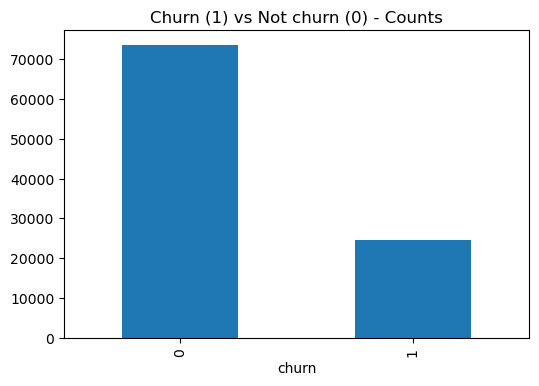

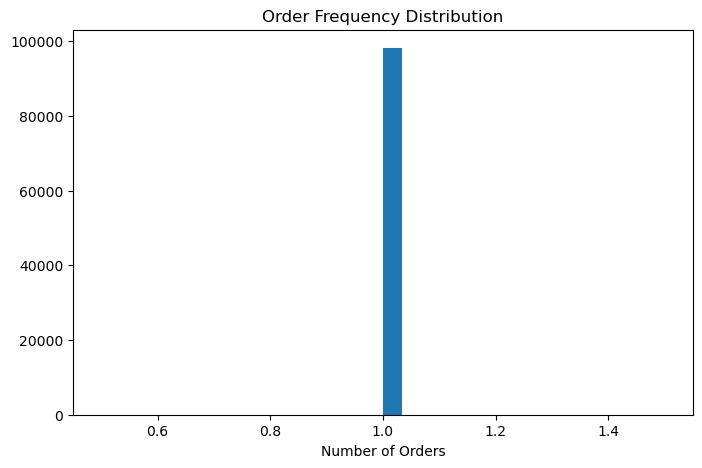

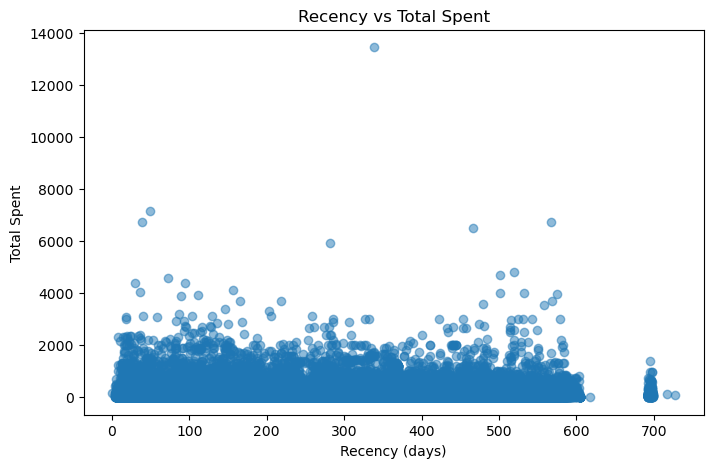

In [28]:

# Simple EDA plots
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
cust_agg['churn'].value_counts().plot(kind='bar')
plt.title('Churn (1) vs Not churn (0) - Counts')

plt.figure(figsize=(8,5))
plt.hist(cust_agg['frequency'], bins=30)
plt.title('Order Frequency Distribution')
plt.xlabel('Number of Orders')

plt.figure(figsize=(8,5))
plt.scatter(cust_agg['recency_days'], cust_agg['total_spent'], alpha=0.5)
plt.title('Recency vs Total Spent')
plt.xlabel('Recency (days)')
plt.ylabel('Total Spent')

plt.show()

In [29]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance
if has_smote:
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)
    print('After SMOTE, counts:', pd.Series(y_train_res).value_counts().to_dict())
else:
    X_train_res, y_train_res = X_train_scaled, y_train
    print('SMOTE not available; using original training set. Consider installing imbalanced-learn.')


After SMOTE, counts: {0: 58926, 1: 58926}


In [30]:

models = {}
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test_scaled)
models['LogisticRegression'] = (lr, y_pred_lr)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test_scaled)
models['RandomForest'] = (rf, y_pred_rf)

# XGBoost (optional)
if has_xgb:
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_clf.fit(X_train_res, y_train_res)
    y_pred_xgb = xgb_clf.predict(X_test_scaled)
    models['XGBoost'] = (xgb_clf, y_pred_xgb)

# Evaluation
for name, (model, y_pred) in models.items():
    print('==', name, '==')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))
    try:
        print('ROC-AUC:', roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]))
    except Exception:
        pass
    print(classification_report(y_test, y_pred))
    print('\n')

== LogisticRegression ==
Accuracy: 0.9954177485871392
F1: 0.990916431166734
ROC-AUC: 0.9999979950051568
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     14732
           1       0.98      1.00      0.99      4909

    accuracy                           1.00     19641
   macro avg       0.99      1.00      0.99     19641
weighted avg       1.00      1.00      1.00     19641



== RandomForest ==
Accuracy: 1.0
F1: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14732
           1       1.00      1.00      1.00      4909

    accuracy                           1.00     19641
   macro avg       1.00      1.00      1.00     19641
weighted avg       1.00      1.00      1.00     19641





In [31]:

# Feature importance from Random Forest
importances = rf.feature_importances_
feat_imp = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)
feat_imp


,feature,importance
5,recency_days,0.987860
4,avg_delivery_delay,0.006822
1,avg_order_value,0.002218
2,total_spent,0.002156
3,avg_review_score,0.000945
0,frequency,0.000000
6,tenure_days,0.000000


## Save model & Recommendations

- Save the best model using joblib or pickle.
- Use feature importance to build targeted retention campaigns (e.g., customers with high recency and low frequency).
- Consider more advanced features: seasonality, time between orders distribution, product categories, customer cohorts, and lifetime value predictions.

### Next steps
1. Hyperparameter tuning for RandomForest/XGBoost.
2. Build a pipeline that includes categorical features (payment_type, top product categories) and embeddings for product preferences.
3. Deploy the model and create a dashboard for retention teams.

In [32]:

# Example: attach predictions back to customer ids and export
# Select only test customers using X_test's index
cust_preds = cust_agg.loc[X_test.index, ['customer_id', 'customer_unique_id']].copy()
cust_preds['churn_pred_rf'] = models['RandomForest'][0].predict(X_test_scaled)
cust_preds['churn_prob_rf'] = models['RandomForest'][0].predict_proba(X_test_scaled)[:,1]

# Save to CSV in the current working directory
cust_preds.to_csv('customer_churn_predictions_sample.csv', index=False)
print('Sample predictions saved to customer_churn_predictions_sample.csv')

Sample predictions saved to customer_churn_predictions_sample.csv
